In [146]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [147]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [148]:
def rmsle(ytrue, y):
    return np.sqrt(mean_squared_log_error(ytrue,y))

In [149]:
df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('test.tsv', sep='\t')

In [150]:
df_train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [151]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (1482535, 8)
Training data shape: (693359, 7)


In [152]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: True
Is null on test: True


In [153]:
df_train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [154]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


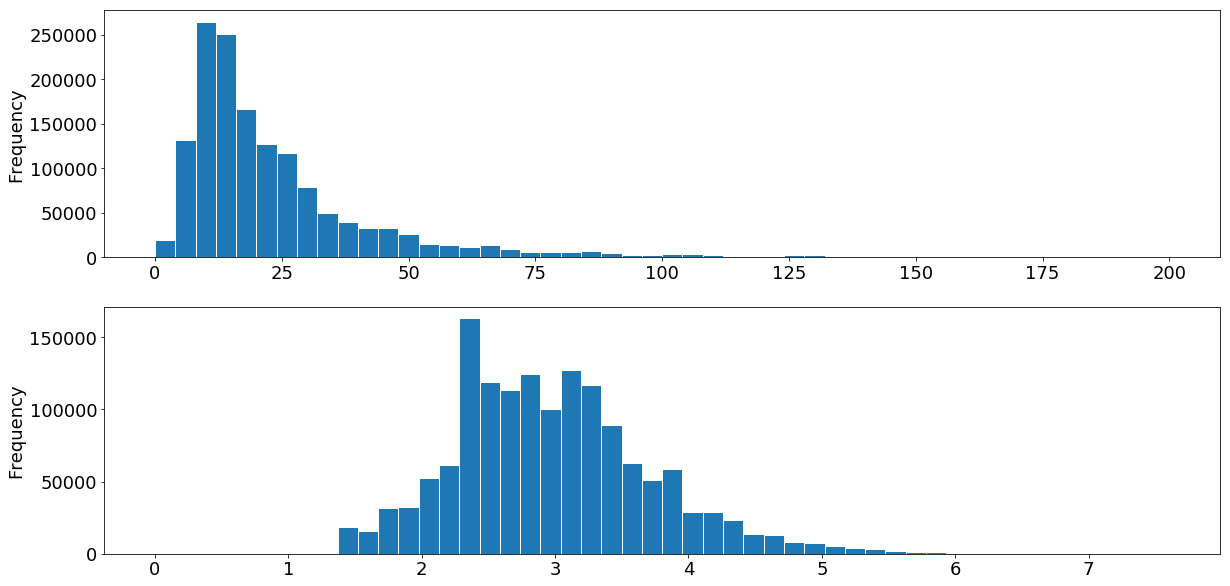

In [21]:
plt.subplot(211)
(df_train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white', range=[0,200])

plt.subplot(212)
np.log(df_train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')

In [155]:
df_train['shipping'].value_counts()/len(df_train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [156]:
df_train['item_condition_id'].value_counts()/len(df_train)

1    0.432063
3    0.291501
2    0.253268
4    0.021559
5    0.001608
Name: item_condition_id, dtype: float64

In [157]:
price_owner = df_train.loc[df_train['shipping'] == 0, 'price']
price_customer = df_train.loc[df_train['shipping'] == 1, 'price']

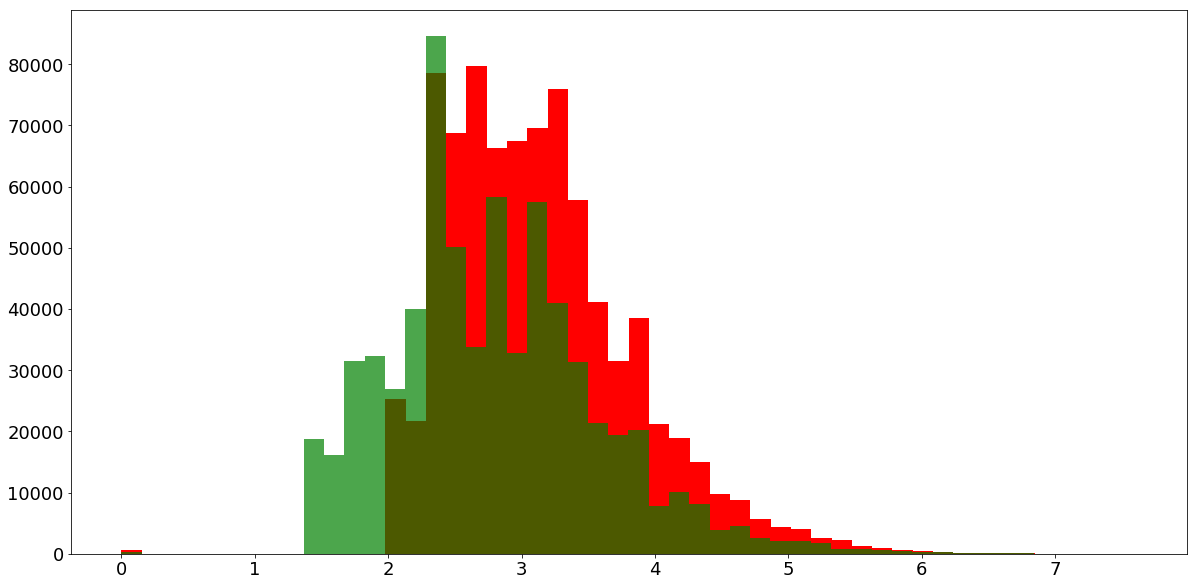

In [158]:
fig, ax= plt.subplots(figsize=(20, 10))
ax.hist(np.log(price_owner+1), bins= 50, color='red', alpha=1.0)
ax.hist(np.log(price_customer+1), bins= 50, color='green', alpha=0.70)
plt.show()

### Brand name analysis

In [159]:
df_train['brand_name'].fillna(value='unknown', inplace=True)

In [160]:
price_brand = df_train['price'].groupby(df_train['brand_name']).describe()

In [178]:
x_mean_brand, y_mean_brand = zip(*sorted(dict(price_brand['mean']).items(), key=lambda x: x[1]))

In [184]:
trace_brand = go.Scatter(x = x_mean_brand, y = np.log(y_mean_brand))
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Price'),
              xaxis = dict(title='Brand name'))
fig=dict(data=[trace_brand], layout= layout)
py.iplot(fig)

In [163]:
len(df_train['category_name'].value_counts())

1287

In [164]:
def split_category(text):
    try: return text.split('/')
    except: return ['No Label', 'No Label', 'No Label']
     
df_train['root_cat'], df_train['sub_cat1'], df_train['sub_cat2'] = \
zip(*df_train['category_name'].apply(lambda x : split_category(x) ))
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,root_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,unknown,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,unknown,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,unknown,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [165]:
aa = dict(Counter(df_train['root_cat']))
sorted_cats = sorted(aa.items(), key=lambda x: x[1])
print(sorted_cats)
x, y = zip(*sorted_cats)

[('No Label', 6327), ('Sports & Outdoors', 25342), ('Handmade', 30842), ('Other', 45351), ('Vintage & Collectibles', 46530), ('Home', 67871), ('Men', 93680), ('Electronics', 122690), ('Kids', 171689), ('Beauty', 207828), ('Women', 664385)]


In [166]:
trace1 = go.Bar(x=x, y=y)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout= layout)
py.iplot(fig)

In [167]:
price_cat = df_train['price'].groupby(df_train['root_cat']).describe()

In [168]:
x_mean, y_mean = zip(*sorted(dict(price_cat['mean']).items(), key=lambda x: x[1]))

In [169]:
trace1 = go.Scatter(x = x_mean, y = np.log(y_mean))
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Price'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout= layout)
py.iplot(fig)

In [170]:
len(df_train['sub_cat1'].unique()), len(df_train['sub_cat2'].unique())

(114, 871)

In [171]:
price_sub_cat1 = df_train['price'].groupby(df_train['sub_cat1']).describe()

In [172]:
x_mean, y_mean = zip(*sorted(dict(price_sub_cat1['mean']).items(), key=lambda x: x[1]))

In [175]:
trace1 = go.Scatter(x = x_mean, y = np.log(y_mean))
layout = dict(title= 'Number of Items by Sub_category1',
              yaxis = dict(title='Price'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout= layout)
py.iplot(fig)

In [181]:
price_sub_cat2 = df_train['price'].groupby(df_train['sub_cat2']).describe()
x_mean, y_mean = zip(*sorted(dict(price_sub_cat2['mean']).items(), key=lambda x: x[1]))

In [182]:
trace1 = go.Scatter(x = x_mean, y = np.log(y_mean))
layout = dict(title= 'Number of Items by Sub_category2',
              yaxis = dict(title='Price'),
              xaxis = dict(title='Sub Category 2'))
fig=dict(data=[trace1], layout= layout)
py.iplot(fig)

## Item description

In [65]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
#         words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [66]:
# add a column of word counts to both the training and test set
df_train['desc_len'] = df_train['item_description'].apply(lambda x: wordCount(x))
df_test['desc_len'] = df_test['item_description'].apply(lambda x: wordCount(x))

In [67]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,root_cat,sub_cat1,sub_cat2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0


In [72]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  Searched in:
    - '/Users/sabber/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/nltk_data'
    - '/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/nltk_data'
**********************************************************************
